# Measurement of $L_{X}$, $T_{X}$, and $R_{500}$ through iterative spectral fitting

Here we measure global X-ray properties of galaxy clusters within physically motiviated apertures (i.e. the common scale radius, $R_{500}$); this also involves measuring the radius itself. We make use of an XGA pipeline to iteratively measure the luminosity, temperature, and $R_{500}$ for our clusters - a start aperture is chosen, within which spectra are generated and fit, and then the measured temperature is used to estimate the $R_{500}$ - this radius is then used to generate more spectra, and so on. The process ends if a radius convergence specified by the user is reached, or if a maximum number of iterations (also specified by the user) is hit.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.tools import luminosity_temperature_pipeline
from xga.relations.fit import scaling_relation_odr, scaling_relation_curve_fit
from xga.models.misc import straight_line, power_law

%matplotlib inline

## Defining the cosmology

We make use of a concordance LambdaCDM model:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Defining useful values

Here we define any widely used constants:

In [3]:
# The energy bands we wish to measure luminosity within
lum_en = Quantity([[0.5, 2.0], [0.01, 100.0], [0.1, 2.4]], 'keV')

## Reading in the sample

We need the information from our sample file to declare the XGA ClusterSample further down, primarily the location and redshift, but we also make use of the MCXC estimate of $R_{500}$ to get some idea of the scale of these objects, even if we don't fully trust that measurement:

In [4]:
samp = pd.read_csv('../../sample_files/X-LoVoCCSI.csv')
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
og_samp = samp.copy()
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4,LoVoCCS_name
0,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,8.726709e+44,LoVoCCS-1
1,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,6.088643e+44,LoVoCCS-2
2,4A,A85North,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,5.100085e+44,LoVoCCS-4A
3,4B,A85South,10.451487,-9.460007,0.0555,1.2103,10.45875,-9.301944,10.451487,-9.460007,5.100085e+44,LoVoCCS-4B
4,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,4.871933e+44,LoVoCCS-5
...,...,...,...,...,...,...,...,...,...,...,...,...
62,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,1.101682e+44,LoVoCCS-121
63,122,A1023,157.000000,-6.800000,0.1176,0.8553,157.00000,-6.800000,NaN,NaN,1.095941e+44,LoVoCCS-122
64,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,1.093054e+44,LoVoCCS-123
65,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,1.063423e+44,LoVoCCS-131


Here we remove some of the existing columns from the sample, that way they won't be included in the output results file for the LTR run, as well as making sure the column names are those expected by the pipeline:

In [5]:
samp = samp[['LoVoCCS_name', 'start_ra', 'start_dec', 'MCXC_Redshift']]
samp = samp.rename(columns={'LoVoCCS_name': 'name', 'start_ra': 'ra', 'start_dec': 'dec', 
                            'MCXC_Redshift': 'redshift'})

## Running the XGA $L_{\rm{X}}$-$T_{\rm{X}}$-$R_{500}$ pipeline

The pipeline is fully described in the X-LoVoCCS paper (as well as explained in the [XGA documentation](https://xga.readthedocs.io/en/latest/notebooks/pipeline_tutorials/LT_pipeline.html)), but it essentially iteratively generates and fits global spectra to a sample of galaxy clusters, using the output temperature to predict the $R_{500}$ (or other overdensity radius) at each step.

### Metallicity free

The first run of the pipeline allows the metallicity to vary freely - our clusters are generally well observed so this is likely an appropriate choice:

In [6]:
res_file = '../../outputs/results/ltr_r500_metfree_pipeline_results.csv'
rhist_file = '../../outputs/results/ltr_r500_metfree_radii_history.csv'

srcs_mfree, results_mfree, rad_hist_mfree = luminosity_temperature_pipeline(samp, Quantity(500, 'kpc'), 
                                                                            timeout=Quantity(4, 'hr'), 
                                                                            freeze_met=False, 
                                                                            save_samp_results_path=res_file, 
                                                                            save_rad_history_path=rhist_file, 
                                                                            core_excised=True, use_peak=False,
                                                                            lum_en=lum_en, clean_obs_threshold=0.9)

Setting up Galaxy Clusters: 100%|██████████| 64/64 [33:04<00:00, 31.00s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/tools/clusters/LT.py:257: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-55, LoVoCCS-108, LoVoCCS-122, LoVoCCS-33, LoVoCCS-41C
  samp = ClusterSample(sample_data['ra'].values, sample_data['dec'].values, sample_data['redshift'].values,
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Generating products of type(s) spectrum: 100%|██████████| 5/5 [24:17<00:00, 291.58s/it]
/tmp/local/40970042/ipykernel_2991495/3759895578.py:5: UserWarning: Some sources (LoVoCCS-11) have been removed because of spectrum generation failures.
  srcs_mfree, results_mfree, rad_hist_mfree = luminosity

### Metallicity fixed

We also do a run of the pipeline with the metallicity frozen, for comparison purposes:

In [ ]:
res_file = '../../outputs/results/ltr_r500_pipeline_results.csv'
rhist_file = '../../outputs/results/ltr_r500_radii_history.csv'

srcs, results, rad_hist = luminosity_temperature_pipeline(samp, Quantity(500, 'kpc'), timeout=Quantity(4, 'hr'), 
                                                          freeze_met=True, save_samp_results_path=res_file,
                                                          save_rad_history_path=rhist_file, 
                                                          core_excised=True, use_peak=False, lum_en=lum_en, clean_obs_threshold=0.9)

Setting up Galaxy Clusters: 100%|██████████| 64/64 [40:14<00:00, 37.72s/it]  
/mnt/ufs18/home-218/turne540/code/XGA/xga/tools/clusters/LT.py:257: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-55, LoVoCCS-108, LoVoCCS-122, LoVoCCS-33, LoVoCCS-41C
  samp = ClusterSample(sample_data['ra'].values, sample_data['dec'].values, sample_data['redshift'].values,
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Generating products of type(s) spectrum: 100%|██████████| 5/5 [24:29<00:00, 293.99s/it]
/tmp/local/41017043/ipykernel_3187989/417030032.py:4: UserWarning: Some sources (LoVoCCS-11) have been removed because of spectrum generation failures.
  srcs, results, rad_hist = luminosity_temperature_pipe

## Comparing results with MCXC values

We create some figures comparing the measured values to those in the MCXC catalogue that LoVoCCS was initially selected from. We load in the results files here (though we also output them to variables when running the pipelines, this allows the figure section of this notebook to be run by itself, without re-running the pipelines unnecessarily):

In [6]:
results_mfree = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
results_mfree = results_mfree.rename(columns={'name': 'LoVoCCS_name'})
results = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
results = results.rename(columns={'name': 'LoVoCCS_name'})

results_mfree = pd.merge(results_mfree, og_samp, on='LoVoCCS_name')
results = pd.merge(results, og_samp, on='LoVoCCS_name')
results.tail(5)

,LoVoCCS_name,ra,dec,redshift,nH,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Lx500_0.1-2.4,Lx500_0.1-2.4-,Lx500_0.1-2.4+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,Lx500ce_0.1-2.4,Lx500ce_0.1-2.4-,Lx500ce_0.1-2.4+,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4
57,LoVoCCS-119,125.258665,7.863501,0.1100,0.0187,746.565451,12.969338,2.758462,0.022557,0.022573,6.342910e+43,2.202107e+41,3.226634e+41,1.593085e+44,1.254152e+42,7.516621e+41,1.039177e+44,4.962832e+41,6.074436e+41,3.338040,0.049147,0.049172,3.414133e+43,2.425278e+41,2.165762e+41,9.269345e+43,1.103886e+42,7.631471e+41,5.573797e+43,4.349593e+41,5.636111e+41,119,RX J0820.9+0751/RXC J0821.0+0751,125.258665,7.863501,0.1100,0.8614,125.26000,7.870000,125.258665,7.863501,1.110969e+44
58,LoVoCCS-121,52.466189,-52.580728,0.0624,0.0126,792.972570,14.474856,2.981783,0.045159,0.045158,4.865166e+43,2.845521e+41,1.700656e+41,1.262162e+44,9.754976e+41,1.035123e+42,7.962712e+43,6.269632e+41,5.369854e+41,2.964870,0.054415,0.054414,3.981797e+43,2.188503e+41,3.251660e+41,1.030636e+44,1.209486e+42,1.224335e+42,6.517622e+43,6.383749e+41,3.911145e+41,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,1.101682e+44
59,LoVoCCS-123,193.670000,-29.220000,0.0544,0.0602,953.985525,19.257516,0.333652,0.005182,0.005401,3.198709e+43,4.060135e+41,4.728061e+41,6.117850e+43,1.056354e+42,7.917469e+41,5.491046e+43,6.628425e+41,1.096454e+42,4.084540,0.183133,0.199084,3.899332e+43,6.212016e+41,6.193793e+41,1.158569e+44,3.676956e+42,3.331082e+42,6.341219e+43,9.761276e+41,1.604463e+42,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,1.093054e+44
60,LoVoCCS-131,137.651250,-10.581111,0.0916,0.0467,999.796416,22.831154,4.531527,0.154899,0.157314,1.034803e+44,1.038565e+42,1.467438e+42,3.226296e+44,8.665477e+42,5.901290e+42,1.679929e+44,2.606289e+42,2.678066e+42,4.662187,0.192772,0.222459,7.589774e+43,1.398152e+42,1.349620e+42,2.397954e+44,7.782074e+42,6.439379e+42,1.231559e+44,1.800006e+42,2.907455e+42,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,1.063423e+44
61,LoVoCCS-134,329.604682,-60.413676,0.0750,0.0292,875.952921,18.651163,3.588662,0.098297,0.096583,5.059858e+43,2.876896e+41,4.997269e+41,1.418475e+44,2.953552e+42,2.208082e+42,8.248594e+43,9.482661e+41,1.038445e+42,3.565836,0.108231,0.107411,4.551054e+43,4.860400e+41,4.216978e+41,1.272254e+44,2.616869e+42,2.375147e+42,7.420065e+43,6.542892e+41,1.109821e+42,134,A3825,329.604682,-60.413676,0.0750,0.8685,329.61000,-60.400000,329.604682,-60.413676,1.050267e+44


In [7]:
results_mfree.tail(5)

,LoVoCCS_name,ra,dec,redshift,nH,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Lx500_0.1-2.4,Lx500_0.1-2.4-,Lx500_0.1-2.4+,Zmet500,Zmet500-,Zmet500+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,Lx500ce_0.1-2.4,Lx500ce_0.1-2.4-,Lx500ce_0.1-2.4+,Zmet500ce,Zmet500ce-,Zmet500ce+,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4
57,LoVoCCS-119,125.258665,7.863501,0.1100,0.0187,755.647355,12.943801,2.818149,0.023852,0.023789,6.375321e+43,3.323362e+41,1.978029e+41,1.613694e+44,1.165134e+42,1.214628e+42,1.038000e+44,4.088157e+41,4.185867e+41,0.366343,0.010805,0.011003,3.252897,0.058963,0.059376,3.431302e+43,2.866711e+41,2.089164e+41,9.203118e+43,1.262411e+42,1.137305e+42,5.637847e+43,4.075244e+41,4.835021e+41,0.219667,0.016579,0.017638,119,RX J0820.9+0751/RXC J0821.0+0751,125.258665,7.863501,0.1100,0.8614,125.26000,7.870000,125.258665,7.863501,1.110969e+44
58,LoVoCCS-121,52.466189,-52.580728,0.0624,0.0126,777.699067,14.664985,2.934197,0.048295,0.048306,4.781987e+43,2.708343e+41,3.105259e+41,1.232800e+44,1.440652e+42,9.051515e+41,7.885787e+43,5.658136e+41,5.692074e+41,0.216362,0.015169,0.015582,2.872319,0.054696,0.058847,3.931597e+43,3.169465e+41,3.012054e+41,1.005581e+44,1.051188e+42,1.234911e+42,6.511865e+43,5.212782e+41,5.401715e+41,0.176725,0.016629,0.017092,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,1.101682e+44
59,LoVoCCS-123,193.670000,-29.220000,0.0544,0.0602,940.990799,20.114889,3.954231,0.116500,0.116223,6.853635e+43,6.708283e+41,7.149724e+41,1.995758e+44,3.550633e+42,3.984978e+42,1.123025e+44,9.565751e+41,1.022613e+42,0.170757,0.034984,0.036128,3.650161,0.200605,0.187892,3.971605e+43,6.889246e+41,9.901746e+41,1.111348e+44,2.314940e+42,4.362940e+42,6.595439e+43,1.557016e+42,1.680082e+42,0.010044,0.010044,0.047885,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,1.093054e+44
60,LoVoCCS-131,137.651250,-10.581111,0.0916,0.0467,988.545194,23.753493,4.443321,0.162246,0.165596,1.031841e+44,1.859119e+42,1.851207e+42,3.170048e+44,7.100995e+42,7.720929e+42,1.682860e+44,2.517075e+42,2.011857e+42,0.200874,0.047903,0.050394,4.567599,0.213285,0.209522,7.604813e+43,1.500883e+42,1.581125e+42,2.367314e+44,6.597241e+42,9.286057e+42,1.238996e+44,3.242629e+42,2.424638e+42,0.208800,0.063018,0.067603,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,1.063423e+44
61,LoVoCCS-134,329.604682,-60.413676,0.0750,0.0292,839.989122,19.500890,3.434125,0.098822,0.105231,4.958972e+43,4.637212e+41,5.329929e+41,1.356899e+44,2.587479e+42,1.563690e+42,8.215190e+43,7.699282e+41,6.701891e+41,0.083851,0.027178,0.028188,3.418311,0.106622,0.113948,4.475010e+43,4.673847e+41,5.555815e+41,1.222272e+44,1.955971e+42,2.864152e+42,7.414204e+43,1.149632e+42,8.425778e+41,0.085347,0.029396,0.030710,134,A3825,329.604682,-60.413676,0.0750,0.8685,329.61000,-60.400000,329.604682,-60.413676,1.050267e+44


### Comparing MCXC and X-LoVoCCS luminosities

We measured luminosities in the 0.1-2.4 keV band that was utilised for MCXC, so we compare our measurements (with our own derived values of $R_{500}$) with the original measurements - this is interesting primarily because the MCXC luminosities were one of the key selection criteria for the LoVoCCS sample. Remember also that we ran with metallicity free and with it fixed, so two comparisons are necessary:

In [8]:
lx_comp = scaling_relation_curve_fit(straight_line, Quantity(results['Lx500_0.1-2.4'], 'erg/s'), 
                                     Quantity(results[['Lx500_0.1-2.4-', 'Lx500_0.1-2.4+']], 'erg/s'), 
                                     Quantity(results['MCXC_Lx500_0.1_2.4'], 'erg/s'), 
                                     y_norm=Quantity(1e+44, 'erg/s'), 
                                     x_norm=Quantity(1e+44, 'erg/s'), point_names=results['LoVoCCS_name'].values, 
                                     y_name=r'$L^{0.1-2.4\rm{keV}}_{\rm{XMM},500}$', 
                                     x_name=r'$L^{0.1-2.4\rm{keV}}_{\rm{MCXC},500}$', 
                                     third_dim_info=results['redshift'].values, third_dim_name='Redshift')

lx_comp_mfree = scaling_relation_curve_fit(straight_line, Quantity(results_mfree['Lx500_0.1-2.4'], 'erg/s'), 
                                           Quantity(results_mfree[['Lx500_0.1-2.4-', 'Lx500_0.1-2.4+']], 'erg/s'), 
                                           Quantity(results_mfree['MCXC_Lx500_0.1_2.4'], 'erg/s'), 
                                           y_norm=Quantity(1e+44, 'erg/s'), 
                                           x_norm=Quantity(1e+44, 'erg/s'), point_names=results_mfree['LoVoCCS_name'].values, 
                                           y_name=r'$L^{0.1-2.4\rm{keV}}_{\rm{XMM},500}$', 
                                           x_name=r'$L^{0.1-2.4\rm{keV}}_{\rm{MCXC},500}$', 
                                           third_dim_info=results_mfree['redshift'].values, third_dim_name='Redshift')

/mnt/ufs18/home-218/turne540/code/XGA/xga/relations/fit.py:224: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, point_names=point_names,
/mnt/ufs18/home-218/turne540/code/XGA/xga/relations/fit.py:224: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, point_names=point_names,


#### Metallicity free

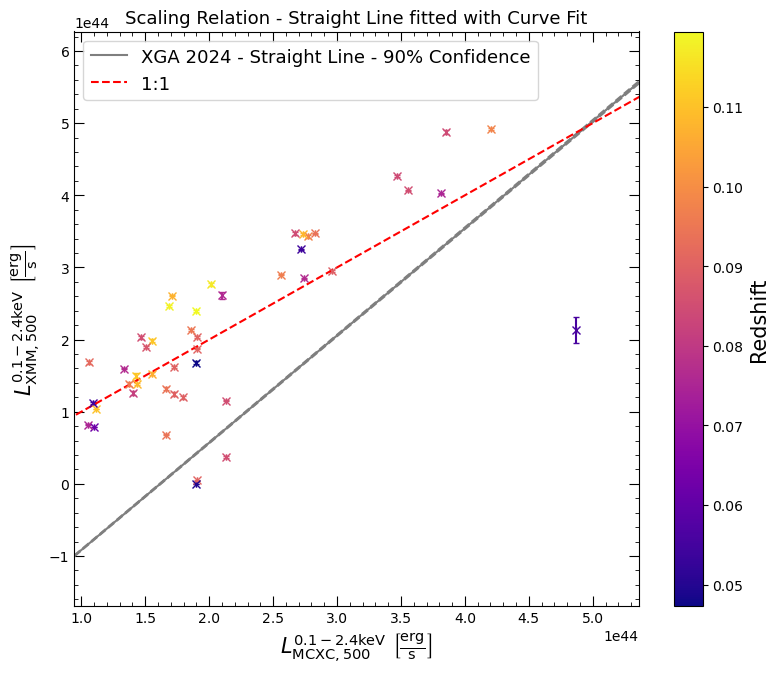

['gradient', 'intercept']


array([[ 1.48640271e+00,  1.70131033e-03],
       [-2.40309603e+00,  3.37825972e-03]])

In [9]:
lx_comp_mfree.view(figsize=(8, 7), label_points=False, log_scale=False, one_to_one=True, 
                   save_path='../../outputs/figures/global_properties/xmm_mcxc_lx_metfree_comp.pdf')
print(lx_comp_mfree.par_names)
lx_comp_mfree.pars

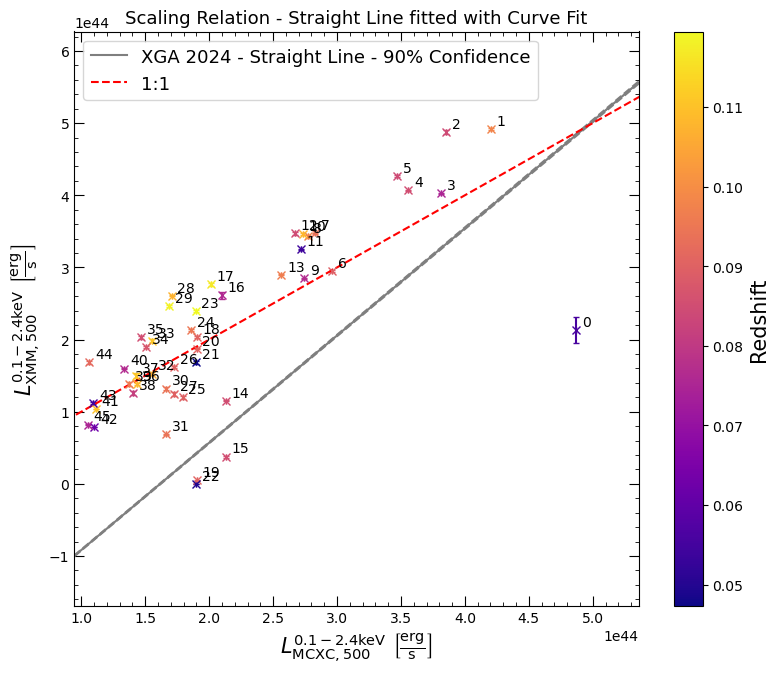

{0: 'LoVoCCS-5',
 1: 'LoVoCCS-7',
 2: 'LoVoCCS-10',
 3: 'LoVoCCS-13',
 4: 'LoVoCCS-15',
 5: 'LoVoCCS-18',
 6: 'LoVoCCS-22',
 7: 'LoVoCCS-24',
 8: 'LoVoCCS-26',
 9: 'LoVoCCS-28',
 10: 'LoVoCCS-29',
 11: 'LoVoCCS-30',
 12: 'LoVoCCS-31',
 13: 'LoVoCCS-35',
 14: 'LoVoCCS-41A',
 15: 'LoVoCCS-41B',
 16: 'LoVoCCS-42',
 17: 'LoVoCCS-45',
 18: 'LoVoCCS-46A',
 19: 'LoVoCCS-46B',
 20: 'LoVoCCS-46C',
 21: 'LoVoCCS-48A',
 22: 'LoVoCCS-48B',
 23: 'LoVoCCS-49',
 24: 'LoVoCCS-51',
 25: 'LoVoCCS-58',
 26: 'LoVoCCS-60A',
 27: 'LoVoCCS-60B',
 28: 'LoVoCCS-61',
 29: 'LoVoCCS-63',
 30: 'LoVoCCS-66A',
 31: 'LoVoCCS-66B',
 32: 'LoVoCCS-74',
 33: 'LoVoCCS-75',
 34: 'LoVoCCS-76',
 35: 'LoVoCCS-80',
 36: 'LoVoCCS-85',
 37: 'LoVoCCS-89',
 38: 'LoVoCCS-90',
 39: 'LoVoCCS-94',
 40: 'LoVoCCS-98',
 41: 'LoVoCCS-119',
 42: 'LoVoCCS-121',
 43: 'LoVoCCS-123',
 44: 'LoVoCCS-131',
 45: 'LoVoCCS-134'}

In [28]:
lx_comp_mfree.view(figsize=(8, 7), label_points=True, log_scale=False, one_to_one=True)
{ind: lx_comp_mfree.point_names[ind] for ind in range(0, len(lx_comp_mfree.point_names))}

We also calculate and plot the distribution of ratios between the 0.1-2.4 keV luminosities, as another way of examining the same comparison:

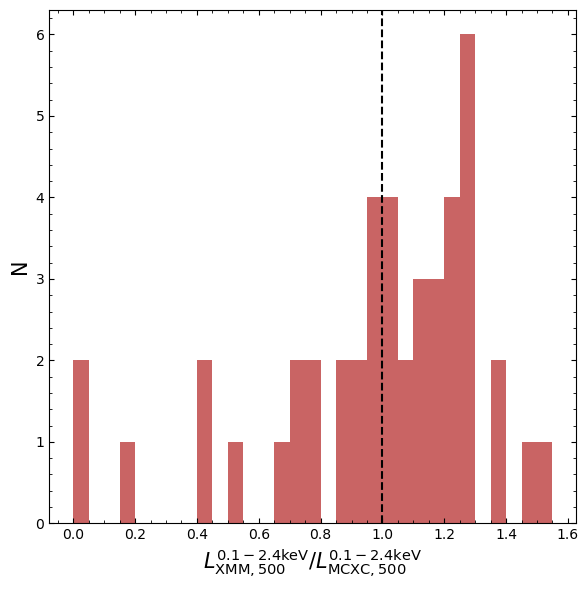

In [11]:
lx_rat = lx_comp_mfree.y_data[:, 0] / lx_comp_mfree.x_data[:, 0]

bins = np.arange(lx_rat.min(), lx_rat.max(), 0.05)

plt.figure(figsize=(6, 6))
plt.hist(lx_rat, bins=bins, color='firebrick', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel(r'$L^{0.1-2.4\rm{keV}}_{\rm{XMM},500} / L^{0.1-2.4\rm{keV}}_{\rm{MCXC},500}$', fontsize=15)
plt.ylabel('N', fontsize=15)
plt.tight_layout()
plt.savefig('../../outputs/figures/global_properties/xmm_mcxc_lx_metfree_ratio.pdf')
plt.show()

#### Metallicity fixed

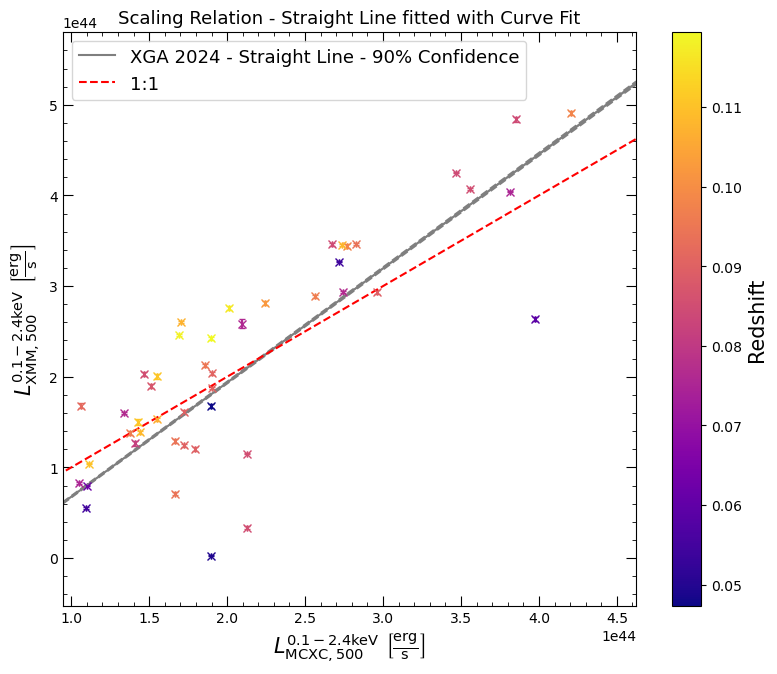

['gradient', 'intercept']


array([[ 1.25957466,  0.00195923],
       [-0.58341332,  0.00444586]])

In [12]:
lx_comp.view(figsize=(8, 7), label_points=False, log_scale=False, one_to_one=True,
             save_path='../../outputs/figures/global_properties/xmm_mcxc_lx_comp.pdf')
print(lx_comp.par_names)
lx_comp.pars

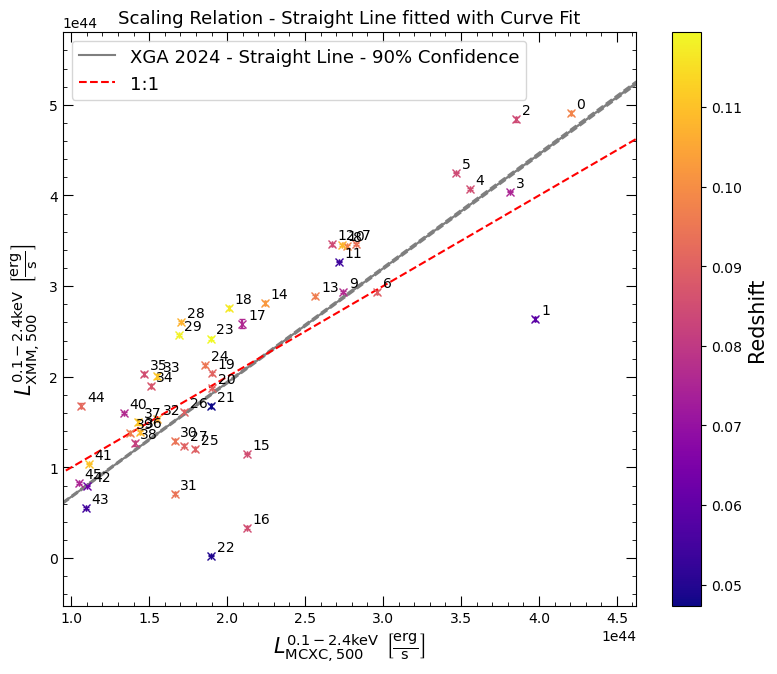

{0: 'LoVoCCS-7',
 1: 'LoVoCCS-9',
 2: 'LoVoCCS-10',
 3: 'LoVoCCS-13',
 4: 'LoVoCCS-15',
 5: 'LoVoCCS-18',
 6: 'LoVoCCS-22',
 7: 'LoVoCCS-24',
 8: 'LoVoCCS-26',
 9: 'LoVoCCS-28',
 10: 'LoVoCCS-29',
 11: 'LoVoCCS-30',
 12: 'LoVoCCS-31',
 13: 'LoVoCCS-35',
 14: 'LoVoCCS-39',
 15: 'LoVoCCS-41A',
 16: 'LoVoCCS-41B',
 17: 'LoVoCCS-42',
 18: 'LoVoCCS-45',
 19: 'LoVoCCS-46A',
 20: 'LoVoCCS-46C',
 21: 'LoVoCCS-48A',
 22: 'LoVoCCS-48B',
 23: 'LoVoCCS-49',
 24: 'LoVoCCS-51',
 25: 'LoVoCCS-58',
 26: 'LoVoCCS-60A',
 27: 'LoVoCCS-60B',
 28: 'LoVoCCS-61',
 29: 'LoVoCCS-63',
 30: 'LoVoCCS-66A',
 31: 'LoVoCCS-66B',
 32: 'LoVoCCS-74',
 33: 'LoVoCCS-75',
 34: 'LoVoCCS-76',
 35: 'LoVoCCS-80',
 36: 'LoVoCCS-85',
 37: 'LoVoCCS-89',
 38: 'LoVoCCS-90',
 39: 'LoVoCCS-94',
 40: 'LoVoCCS-98',
 41: 'LoVoCCS-119',
 42: 'LoVoCCS-121',
 43: 'LoVoCCS-123',
 44: 'LoVoCCS-131',
 45: 'LoVoCCS-134'}

In [27]:
lx_comp.view(figsize=(8, 7), label_points=True, log_scale=False, one_to_one=True)
{ind: lx_comp.point_names[ind] for ind in range(0, len(lx_comp.point_names))}

We also calculate and plot the distribution of ratios between the 0.1-2.4 keV luminosities, as another way of examining the same comparison:

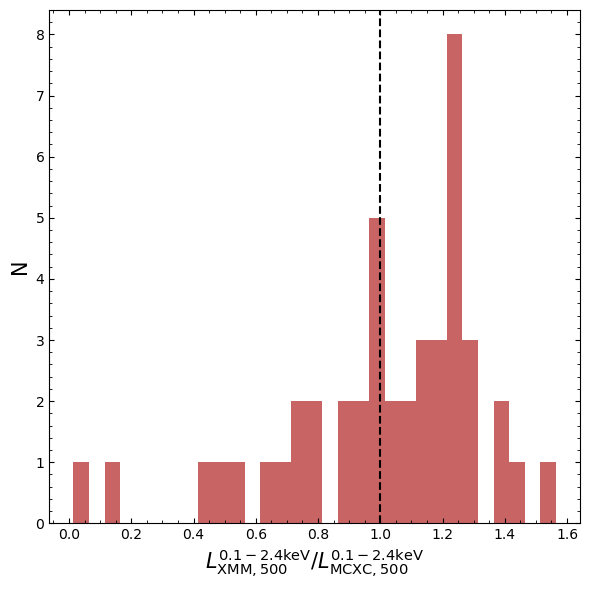

In [14]:
lx_rat = lx_comp.y_data[:, 0] / lx_comp.x_data[:, 0]

bins = np.arange(lx_rat.min(), lx_rat.max(), 0.05)

plt.figure(figsize=(6, 6))
plt.hist(lx_rat, bins=bins, color='firebrick', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel(r'$L^{0.1-2.4\rm{keV}}_{\rm{XMM},500} / L^{0.1-2.4\rm{keV}}_{\rm{MCXC},500}$', fontsize=15)
plt.ylabel('N', fontsize=15)
plt.tight_layout()
plt.savefig('../../outputs/figures/global_properties/xmm_mcxc_lx_ratio.pdf')
plt.show()

### Comparing MCXC and X-LoVoCCS $R_{500}$ values

We have derived our own values of $R_{500}$ using the XGA-LTR, and measured temperatures and luminosities within them - we compare the $R_{500}$ values to those which were measured for the MCXC catalogue - again recall that we ran the pipeline twice, one with metallicity fixed and one with it free, so we will make comparisons with both:

In [22]:
r500_comp = scaling_relation_curve_fit(straight_line, Quantity(results['r500'], 'kpc'), 
                                       Quantity(results['r500+-'], 'kpc'), 
                                       Quantity(results['MCXC_R500'], 'Mpc').to('kpc'), y_norm=Quantity(1, 'kpc'), 
                                       x_norm=Quantity(1, 'kpc'), point_names=results['LoVoCCS_name'].values, 
                                       y_name=r'$R^{\rm{XMM}}_{500}$', 
                                       x_name=r'$R^{\rm{MCXC}}_{500}$', 
                                       third_dim_info=results['redshift'].values, third_dim_name='Redshift')

r500_comp_mfree = scaling_relation_curve_fit(straight_line, Quantity(results_mfree['r500'], 'kpc'), 
                                       Quantity(results_mfree['r500+-'], 'kpc'), 
                                       Quantity(results_mfree['MCXC_R500'], 'Mpc').to('kpc'), y_norm=Quantity(1, 'kpc'), 
                                       x_norm=Quantity(1, 'kpc'), point_names=results_mfree['LoVoCCS_name'].values, 
                                       y_name=r'$R^{\rm{XMM}}_{500}$', 
                                       x_name=r'$R^{\rm{MCXC}}_{500}$', 
                                       third_dim_info=results_mfree['redshift'].values, third_dim_name='Redshift')

#### Metallicity free

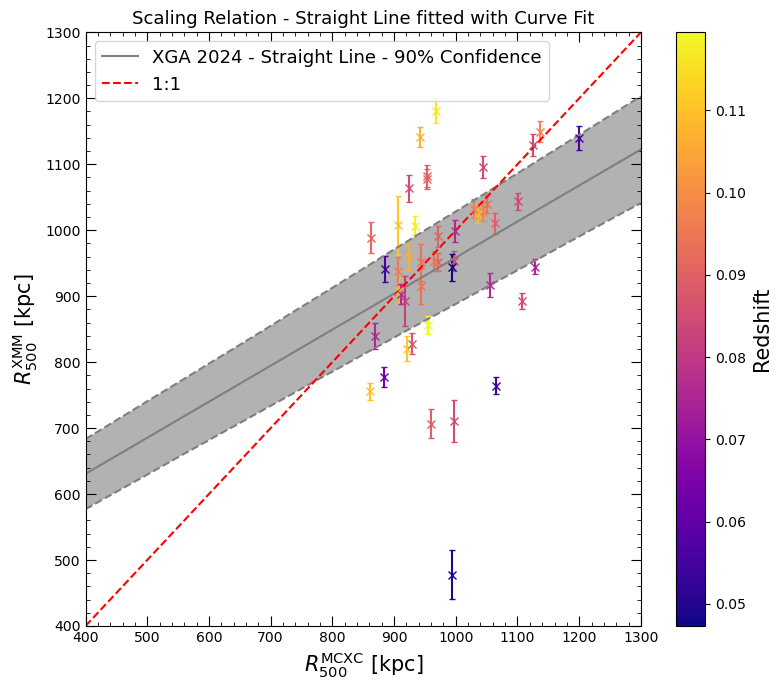

['gradient', 'intercept']


array([[5.46459525e-01, 2.97601990e-02],
       [4.12109633e+02, 2.97760322e+01]])

In [23]:
r500_comp_mfree.view(figsize=(8, 7), label_points=False, log_scale=False, x_lims=Quantity([400, 1300], 'kpc'), one_to_one=True, 
                     y_lims=Quantity([400, 1300], 'kpc'), 
                     save_path='../../outputs/figures/global_properties/xmm_mcxc_r500_mfree_comp.pdf')

print(r500_comp_mfree.par_names)
r500_comp_mfree.pars

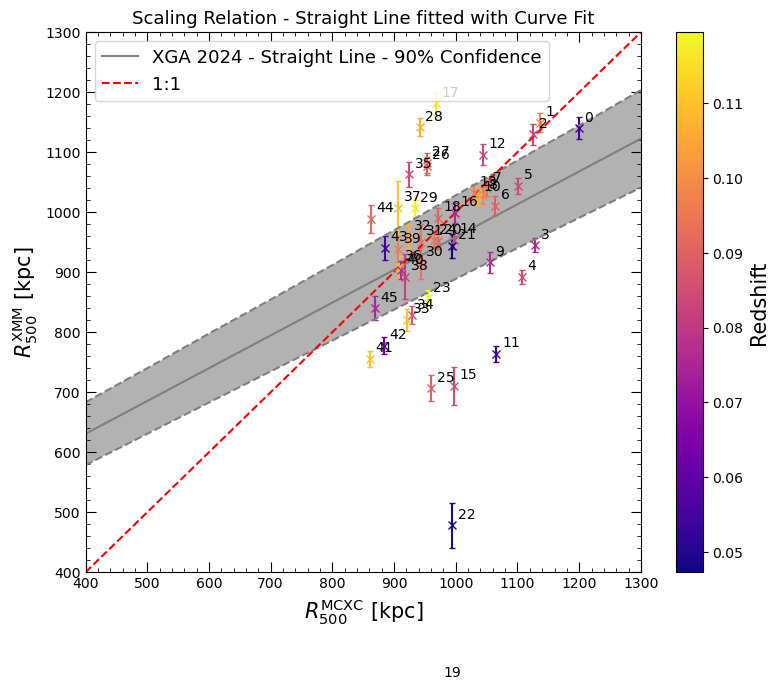

{0: 'LoVoCCS-5',
 1: 'LoVoCCS-7',
 2: 'LoVoCCS-10',
 3: 'LoVoCCS-13',
 4: 'LoVoCCS-15',
 5: 'LoVoCCS-18',
 6: 'LoVoCCS-22',
 7: 'LoVoCCS-24',
 8: 'LoVoCCS-26',
 9: 'LoVoCCS-28',
 10: 'LoVoCCS-29',
 11: 'LoVoCCS-30',
 12: 'LoVoCCS-31',
 13: 'LoVoCCS-35',
 14: 'LoVoCCS-41A',
 15: 'LoVoCCS-41B',
 16: 'LoVoCCS-42',
 17: 'LoVoCCS-45',
 18: 'LoVoCCS-46A',
 19: 'LoVoCCS-46B',
 20: 'LoVoCCS-46C',
 21: 'LoVoCCS-48A',
 22: 'LoVoCCS-48B',
 23: 'LoVoCCS-49',
 24: 'LoVoCCS-51',
 25: 'LoVoCCS-58',
 26: 'LoVoCCS-60A',
 27: 'LoVoCCS-60B',
 28: 'LoVoCCS-61',
 29: 'LoVoCCS-63',
 30: 'LoVoCCS-66A',
 31: 'LoVoCCS-66B',
 32: 'LoVoCCS-74',
 33: 'LoVoCCS-75',
 34: 'LoVoCCS-76',
 35: 'LoVoCCS-80',
 36: 'LoVoCCS-85',
 37: 'LoVoCCS-89',
 38: 'LoVoCCS-90',
 39: 'LoVoCCS-94',
 40: 'LoVoCCS-98',
 41: 'LoVoCCS-119',
 42: 'LoVoCCS-121',
 43: 'LoVoCCS-123',
 44: 'LoVoCCS-131',
 45: 'LoVoCCS-134'}

In [29]:
r500_comp_mfree.view(figsize=(8, 7), label_points=True, log_scale=False, x_lims=Quantity([400, 1300], 'kpc'), one_to_one=True, 
                     y_lims=Quantity([400, 1300], 'kpc'))
{ind: r500_comp_mfree.point_names[ind] for ind in range(0, len(r500_comp_mfree.point_names))}

We again calculate and plot the distribution of ratios, as another way of examining the same comparison:

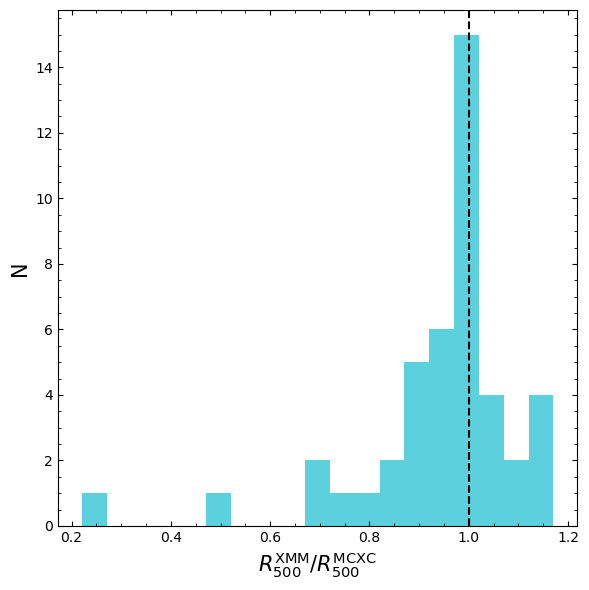

In [26]:
r500_rat = r500_comp_mfree.y_data[:, 0] / r500_comp_mfree.x_data[:, 0]

bins = np.arange(r500_rat.min(), r500_rat.max(), 0.05)

plt.figure(figsize=(6, 6))
plt.hist(r500_rat, bins=bins, color='tab:cyan', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel(r'$R^{\rm{XMM}}_{500} / R^{\rm{MCXC}}_{500}$', fontsize=15)
plt.ylabel('N', fontsize=15)

plt.tight_layout()
plt.savefig('../../outputs/figures/global_properties/xmm_mcxc_r500_mfree_ratio.pdf')
plt.show()

#### Metallicity fixed

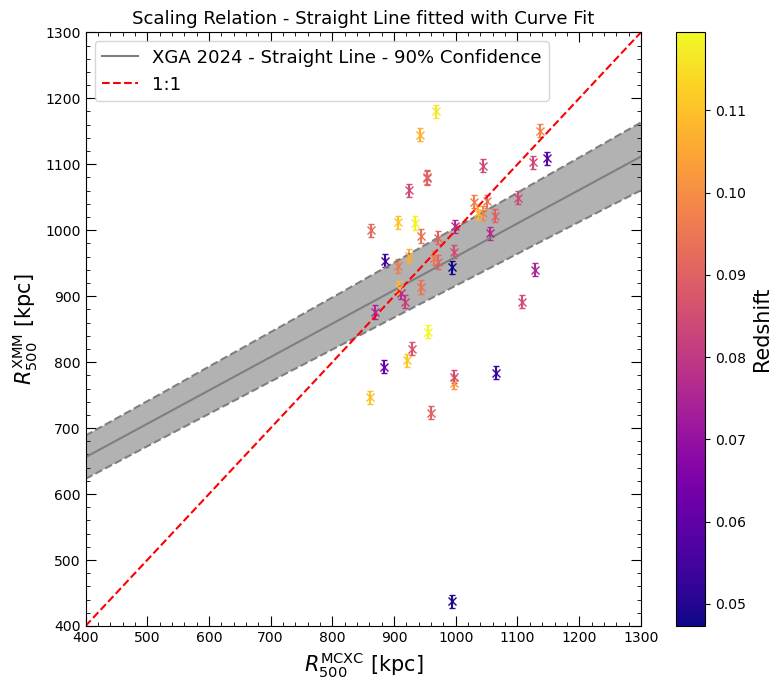

['gradient', 'intercept']


array([[5.06483907e-01, 1.91800665e-02],
       [4.53238415e+02, 1.88972691e+01]])

In [16]:
r500_comp.view(figsize=(8, 7), label_points=False, log_scale=False, x_lims=Quantity([400, 1300], 'kpc'), one_to_one=True, 
               y_lims=Quantity([400, 1300], 'kpc'), save_path='../../outputs/figures/global_properties/xmm_mcxc_r500_comp.pdf')

print(r500_comp.par_names)
r500_comp.pars

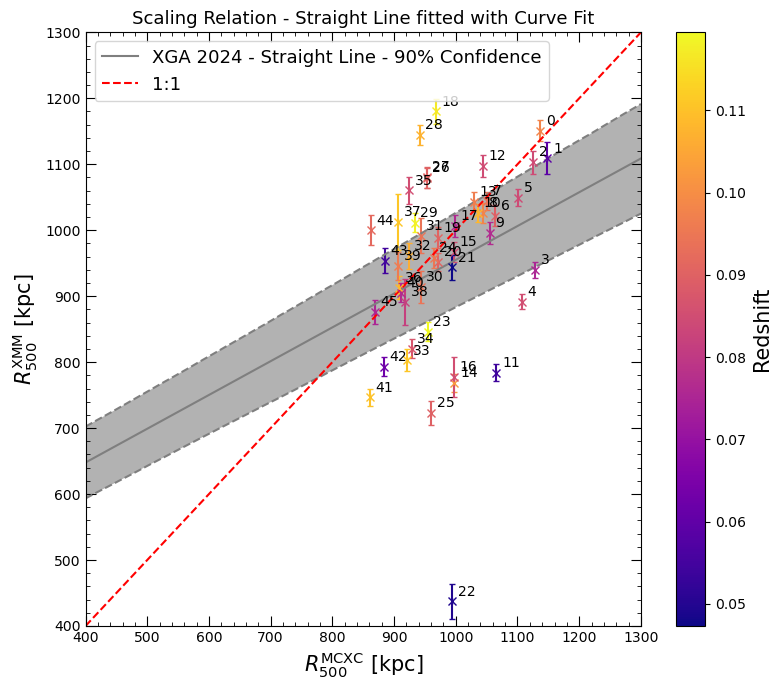

{0: 'LoVoCCS-7',
 1: 'LoVoCCS-9',
 2: 'LoVoCCS-10',
 3: 'LoVoCCS-13',
 4: 'LoVoCCS-15',
 5: 'LoVoCCS-18',
 6: 'LoVoCCS-22',
 7: 'LoVoCCS-24',
 8: 'LoVoCCS-26',
 9: 'LoVoCCS-28',
 10: 'LoVoCCS-29',
 11: 'LoVoCCS-30',
 12: 'LoVoCCS-31',
 13: 'LoVoCCS-35',
 14: 'LoVoCCS-39',
 15: 'LoVoCCS-41A',
 16: 'LoVoCCS-41B',
 17: 'LoVoCCS-42',
 18: 'LoVoCCS-45',
 19: 'LoVoCCS-46A',
 20: 'LoVoCCS-46C',
 21: 'LoVoCCS-48A',
 22: 'LoVoCCS-48B',
 23: 'LoVoCCS-49',
 24: 'LoVoCCS-51',
 25: 'LoVoCCS-58',
 26: 'LoVoCCS-60A',
 27: 'LoVoCCS-60B',
 28: 'LoVoCCS-61',
 29: 'LoVoCCS-63',
 30: 'LoVoCCS-66A',
 31: 'LoVoCCS-66B',
 32: 'LoVoCCS-74',
 33: 'LoVoCCS-75',
 34: 'LoVoCCS-76',
 35: 'LoVoCCS-80',
 36: 'LoVoCCS-85',
 37: 'LoVoCCS-89',
 38: 'LoVoCCS-90',
 39: 'LoVoCCS-94',
 40: 'LoVoCCS-98',
 41: 'LoVoCCS-119',
 42: 'LoVoCCS-121',
 43: 'LoVoCCS-123',
 44: 'LoVoCCS-131',
 45: 'LoVoCCS-134'}

In [30]:
r500_comp.view(figsize=(8, 7), label_points=True, log_scale=False, x_lims=Quantity([400, 1300], 'kpc'), one_to_one=True, 
               y_lims=Quantity([400, 1300], 'kpc'))
{ind: r500_comp.point_names[ind] for ind in range(0, len(r500_comp.point_names))}

We again calculate and plot the distribution of ratios, as another way of examining the same comparison:

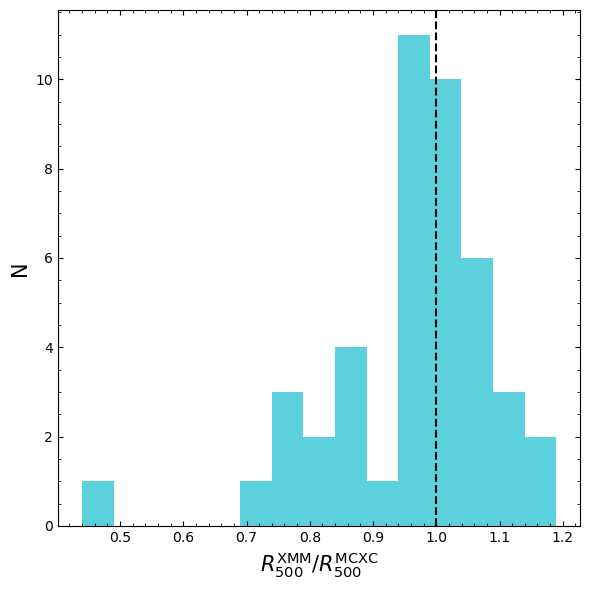

In [18]:
r500_rat = r500_comp.y_data[:, 0] / r500_comp.x_data[:, 0]

bins = np.arange(r500_rat.min(), r500_rat.max(), 0.05)

plt.figure(figsize=(6, 6))
plt.hist(r500_rat, bins=bins, color='tab:cyan', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel(r'$R^{\rm{XMM}}_{500} / R^{\rm{MCXC}}_{500}$', fontsize=15)
plt.ylabel('N', fontsize=15)

plt.tight_layout()
plt.savefig('../../outputs/figures/global_properties/xmm_mcxc_r500_ratio.pdf')
plt.show()